In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
from qumcmc.energy_models import *

from qumcmc.classical_mcmc_routines import classical_mcmc
# from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 
# from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc   #for qulacs backend (**faster)
from QuantumSamplingRoutines import *
from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics

import pickle, json 
import networkx as nx

In [2]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile, transpiler
from qiskit.visualization import *
from qiskit_ibm_provider import IBMProvider
# # provider = IBMProvider(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628')
# # provider.save_account(token= '0c4a11984552ee16d40f9f7ad8848d8393c9010d55e924306fbc7486c2c55927173b79841d947e255fdbc927079265ed02aa66f10895a50367a0fd97bc6de628', overwrite= True)
provider = IBMProvider()
ibmq_guadalupe = provider.get_backend('ibmq_guadalupe'); ibmq_lima = provider.get_backend('ibmq_lima')

#### DEFINE MODEL

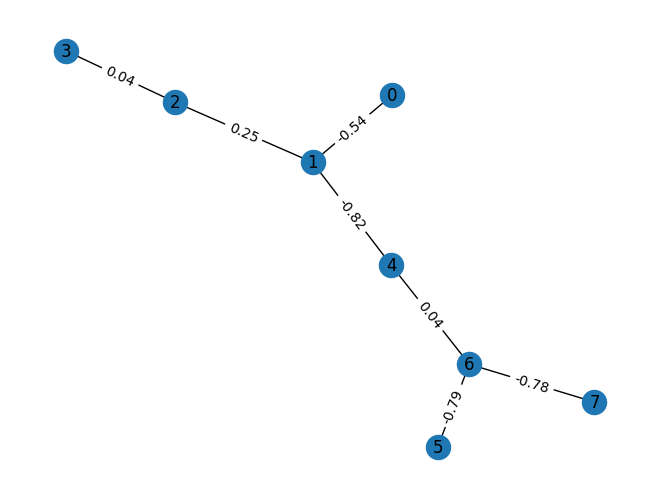

In [3]:
node_to_qubit_map = {0: 0, 1:1, 2:2, 3:3, 4:4, 5:6, 6:7, 7: 10}
qubit_to_node_map = dict([(item[1], item[0]) for item in node_to_qubit_map.items()])

map_node_to_qubit = lambda x: node_to_qubit_map[x]
map_qubit_to_node = lambda x: qubit_to_node_map[x]

device_nodes = [0,1,2,3,4,6,7,10]
device_edges = [(0,1),(1,4),(4,7),(7,10),(7,6),(1,2),(2,3)]

graph_nodes = [0,1,2,3,4,5,6,7]

graph_edges = []
for edge in device_edges:
    i = map_qubit_to_node(edge[0])
    j = map_qubit_to_node(edge[1])
    new_edge = (i,j)
    graph_edges.append(new_edge)
    
trial_graph = nx.Graph(name= "ising_1")
trial_graph.add_nodes_from(graph_nodes)
trial_graph.add_edges_from(graph_edges)

h = [0.1, 0.3, 0.4, 0.21, 0.38, 0.15, 0.25, 0.10]
node_attr = {}
for index, node in enumerate(trial_graph.nodes) :

    node_attr[node] = {'h': np.round(h[index] * np.random.choice([1, -1]), 2)}

nx.set_node_attributes(trial_graph, node_attr)
edge_attr = {}
for edge in trial_graph.edges :
    edge_attr[edge] = {'J': np.round(np.random.uniform(-1,1),2)}

nx.set_edge_attributes(trial_graph, edge_attr)
pos = nx.spring_layout(trial_graph)
nx.draw(trial_graph, pos, with_labels= True,)
nx.draw_networkx_edge_labels(trial_graph, pos, edge_labels= nx.get_edge_attributes(trial_graph, 'J'));

In [4]:
def build_energy_function_from_graph(graph: nx.Graph, name:str = 's'):
    
    nspins = graph.number_of_nodes()
    j = nx.get_edge_attributes(graph, 'J')
    J = np.zeros((nspins, nspins))

    for edge in graph.edges():
        J[edge[0], edge[1]] = j[edge]
        J[edge[1], edge[0]] = j[edge]

    H = list(nx.get_node_attributes(graph, 'h').values())    

    return IsingEnergyFunction(J =J, h=H, name= 'sm1')


In [5]:
model = build_energy_function_from_graph(trial_graph, name= 'ising_exp')

#### DEFINE SAMPLING ROUTINE

In [6]:
sampling_job = QuantumSamplingJob(model, ibmq_guadalupe, backend_layout= list(node_to_qubit_map.values()))

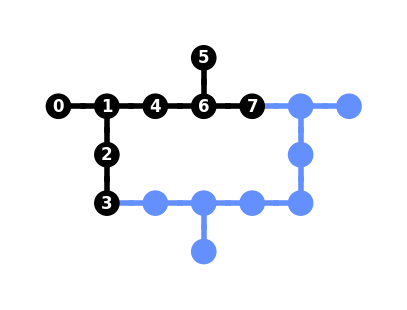

In [7]:
## scartch run 
gamma = 0.8; time = 1.0
qcs = sampling_job.run_quantum_circuit(gamma, time, return_quantum_circuit= True)
qcs = transpile(qcs, ibmq_guadalupe, optimization_level=3, initial_layout= list(node_to_qubit_map.values()) )
plot_circuit_layout(qcs, ibmq_guadalupe)

#### MAIN DATACOLLECTING LOOP

In [10]:
gamma, time 

(0.3025, 6.4)

In [16]:
# gamma_values = list(np.linspace(0.26,0.6,9) )
gamma_values = [ 0.3875, 0.43, 0.515, 0.5575, 0.6];time_values = 0.8 * np.arange(2,12)

In [17]:
# gamma_values = np.linspace(0.26,0.6,9) ;
  ## 9x10 circuits = 90, times 3 for SPAM twirling
all_params = []
for gamma in gamma_values:
    for time in time_values:
        all_params.append((gamma,time))

for gamma,time in all_params:
    for c in range(3): ## For SPAM twirling
           qcs = sampling_job.run_quantum_circuit(gamma, time, num_shots=  10**5 , twirl_counter= c)

Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>


/usr/local/lib/python3.10/dist-packages/qiskit_ibm_provider/ibm_backend.py:431: UserWarning: The backend ibmq_guadalupe is currently paused.
  warnings.warn(f"The backend {self.name} is currently paused.")


Execution Completed in : 33.0668842792511
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 33.441484689712524
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 33.17222023010254
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 34.42953276634216
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 34.08905863761902
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 34.36565375328064
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 34.911985874176025
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 35.03446674346924
Circuit Built. Executing on backend : <IBMBackend('ibmq_guadalupe')>
Execution Completed in : 34.983922481536865
Circuit Built. Executing on backend : <IBMBackend('ibmq_gua